In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tifffile as tf
import os
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import cm
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.integrate import odeint

%matplotlib inline

In [2]:
def nanRobustBlur(I, dim):
    V=I.copy()
    V[I!=I]=0
    VV=cv2.blur(V,dim)   
    W=0*I.copy()+1
    W[I!=I]=0
    WW=cv2.blur(W,dim)    
    Z=VV/WW
    return Z 

In [3]:
anisotropy = cv2.imread('img_retardance3D_t000_p000_z044.tif', -1).astype('float32')
orientation = cv2.imread('img_azimuth_t000_p000_z044.tif', -1).astype('float32')
anisotropy = anisotropy[100:200, 100:200]
orientation = orientation[100:200, 100:200]
orientation = orientation / 18000*np.pi
anisotropy = anisotropy / 10000

# anisotropy = np.zeros((40, 40)) + 1
# orientation = np.zeros((40, 40))

In [4]:
# anisotropy[15:25, :] += 25
# anisotropy[:, 15:25] += 25

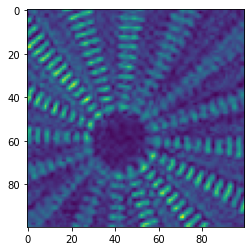

In [5]:
plt.imshow(anisotropy)

In [6]:
def return_smooth(orientation, anisotropy):
    U, V =  anisotropy*np.cos(2 * orientation), anisotropy*np.sin(2 * orientation)
    USmooth = nanRobustBlur(U, (5, 5)) # plot smoothed vector field
    VSmooth = nanRobustBlur(V, (5, 5)) # plot smoothed vector field
    azimuthSmooth = (0.5*np.arctan2(VSmooth,USmooth)) % np.pi
    RSmooth = np.sqrt(USmooth**2+VSmooth**2)
    
    return RSmooth, azimuthSmooth

In [7]:
anisotropy, orientation = return_smooth(orientation, anisotropy)

In [8]:
# # Test
# anisotropy = np.zeros_like(anisotropy) + 3
# orientation = np.zeros_like(orientation) + 0.78539

In [9]:
# def return_D(position):
#     scale_value = anisotropy[position[0]][position[1]]
#     theta = orientation[position[0]][position[1]]
    
#     if scale_value > 1:
#         scale_matrix = np.matrix([[scale_value, 0], [0, scale_value*0.1]])
#     else:
#         scale_matrix = np.matrix([[1, 0], [0, scale_value]])
    
#     angle_matrix = np.matrix([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
#     angle_matrix_2 = np.matrix([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    
#     D_matrix = np.matmul(np.matmul(angle_matrix, scale_matrix), angle_matrix_2)
    
#     return D_matrix

def return_D(position):
    scale_value = anisotropy[position[0]][position[1]]
    theta = orientation[position[0]][position[1]]
    
    if abs(scale_value) > 1:
        scale_matrix = np.matrix([[scale_value, 0], [0, 1]])
    else:
        scale_matrix = np.matrix([[1, 0], [0, scale_value]])
    
    angle_matrix = np.matrix([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    angle_matrix_2 = np.matrix([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    
    D_matrix = np.matmul(np.matmul(angle_matrix, scale_matrix), angle_matrix_2)
    
    return D_matrix

In [10]:
D1 = np.zeros_like(anisotropy, dtype=np.float32)
D2 = np.zeros_like(anisotropy, dtype=np.float32)
D3 = np.zeros_like(anisotropy, dtype=np.float32)
D4 = np.zeros_like(anisotropy, dtype=np.float32)

x = np.arange(0, anisotropy.shape[0], 1)
y = np.arange(0, anisotropy.shape[1], 1)

for i in x:
    for j in y:
        scale_matrix = return_D([i, j])

        D1[i, j] = scale_matrix[0, 0]
        D2[i, j] = scale_matrix[0, 1]
        D3[i, j] = scale_matrix[1, 0]
        D4[i, j] = scale_matrix[1, 1]

In [11]:
from scipy import interpolate

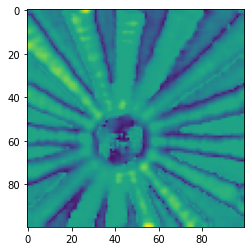

In [12]:
plt.imshow(D1)

In [13]:
D1_interp = interpolate.interp2d(x, y, D1.T, kind='cubic')
D2_interp = interpolate.interp2d(x, y, D2.T, kind='cubic')
D3_interp = interpolate.interp2d(x, y, D3.T, kind='cubic')
D4_interp = interpolate.interp2d(x, y, D4.T, kind='cubic')

In [14]:
def return_D_interp(position):
    D1_value = D1_interp(position[0], position[1])[0]
    D2_value = D2_interp(position[0], position[1])[0]
    D3_value = D3_interp(position[0], position[1])[0]
    D4_value = D4_interp(position[0], position[1])[0]
    
    return np.matrix([[D1_value, D2_value], [D3_value, D4_value]])

In [15]:
D1_int = np.zeros_like(anisotropy, dtype=np.float32)
D2_int = np.zeros_like(anisotropy, dtype=np.float32)
D3_int = np.zeros_like(anisotropy, dtype=np.float32)
D4_int = np.zeros_like(anisotropy, dtype=np.float32)

for i in x:
    for j in y:
        scale_matrix = return_D_interp([i, j])

        D1_int[i, j] = scale_matrix[0, 0]
        D2_int[i, j] = scale_matrix[0, 1]
        D3_int[i, j] = scale_matrix[1, 0]
        D4_int[i, j] = scale_matrix[1, 1]

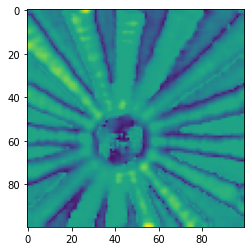

In [16]:
plt.imshow(D1_int)

In [17]:
gamma = 0.5
def force_function(r):
    if 0 < r < 1:
        return r - 1
    elif 1 <= r <= 1 + gamma:
        return ((r-1)*(1+gamma-r)**2)/gamma**2
    elif r > 1 + gamma:
        return 0

In [18]:
def return_D_inverse(pos_a, pos_b, approx=True):
    if approx:
        D_a = return_D_interp(pos_a)
        D_b = return_D_interp(pos_b)

        D_inverse_ab = (np.linalg.inv(D_a) + np.linalg.inv(D_b))/2.0

        return D_inverse_ab
    else:
        mid_pos = tuple(np.add(pos_a, pos_b)/2.0)
        D_ab = return_D_interp(mid_pos)
        
        return np.linalg.inv(D_ab)

In [19]:
alpha = 100
def return_x_ab(pos_a, pos_b, approx=True):
    D_inv_ab = return_D_inverse(pos_a, pos_b, approx)
    
    pos_a = np.asarray(pos_a, dtype='float32')
    pos_b = np.asarray(pos_b, dtype='float32')
    y_ab = pos_a - pos_b
    y_ab = y_ab.reshape((2, 1))
    
    return D_inv_ab.dot(y_ab)/(2*alpha)

In [20]:
from numpy import linalg as LA
def return_force(pos_a, pos_b, approx=True):
    x_ab = return_x_ab(pos_a, pos_b, approx)
    x_ab_dist = LA.norm(x_ab)
    D_inv_ab = return_D_inverse(pos_a, pos_b, approx)

    return (-force_function(x_ab_dist)*D_inv_ab.dot(x_ab))/(2*alpha*x_ab_dist)

In [21]:
initial_num_points = 2000
final_points = 1000
random_rows = np.random.choice(anisotropy.shape[0], initial_num_points)
random_columns = np.random.choice(anisotropy.shape[1], initial_num_points)
random_points = list(zip(random_rows, random_columns))

In [22]:
# Test
# random_points = [(24, 24), (28, 28), (24, 28), (28, 24)]

In [23]:
det_D_list = [np.linalg.det(return_D_interp(pos)) for pos in random_points]
max_det = max(det_D_list)
det_D_list = [x/max_det for x in det_D_list]
points_rejected = np.random.choice(len(random_points), initial_num_points - final_points, det_D_list)
final_points = [random_points[i] for i in range(len(random_points)) if i not in points_rejected]

In [24]:
# final_points = [(24, 24), (28, 28), (24, 28), (28, 24), (26, 26)]

In [25]:
eig_D = [max(np.linalg.eig(return_D_interp(pos))[0]) for pos in random_points]
max_eig = max(eig_D)

In [26]:
edge_length = 2*alpha*max_eig*(1+gamma)

def bin_coords(pos):
    x_coord = np.floor(pos[0]/edge_length)
    y_coord = np.floor(pos[1]/edge_length)
    
    return (x_coord, y_coord)

49.36356086030437
44.46025604653513
49.2985116199924
37.058314034435966
39.667911291711945
37.24413827611254


KeyboardInterrupt: 

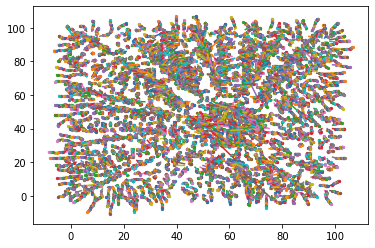

In [27]:
curr_points = final_points

def form_dict(points):
    dict_points = {}

    for point in points:
        bin_coord = bin_coords(point)

        if bin_coord in dict_points.keys():
            dict_points[bin_coord].append(point)
        else:
            dict_points[bin_coord] = [point]
    
    return dict_points

def total_force_on_point(index, list_points, map_points, approx=True):
    p_a = list_points[index]
    bin_coord = bin_coords(p_a)
    bin_x = bin_coord[0]
    bin_y = bin_coord[1]

    points_cons = []
    points_cons += map_points[bin_coord]

    if bin_x - 1 >= 0:
        if (bin_x - 1, bin_y) in map_points.keys():
            points_cons += map_points[(bin_x - 1, bin_y)]

    if bin_y - 1 >= 0:
        if (bin_x, bin_y - 1) in map_points.keys():
            points_cons += map_points[(bin_x, bin_y - 1)]

    if bin_x + 1 < anisotropy.shape[0]:
        if (bin_x + 1, bin_y) in map_points.keys():
            points_cons += map_points[(bin_x + 1, bin_y)]

    if bin_y + 1 < anisotropy.shape[1]:
        if (bin_x, bin_y + 1) in map_points.keys():
            points_cons += map_points[(bin_x, bin_y + 1)]
    
    total_force = np.zeros((2, 1))

    for point in points_cons:
        if point != p_a:
            f = return_force(p_a, point, approx)
            total_force += f

    return total_force

def diff_equation(y, t, c_drag, total_force):
    p0, p1, r0, r1 = y
    dydt = [r0, r1, total_force[0] - c_drag*r0, total_force[1] - c_drag*r1]
    return dydt

def solve_particle_path(index, initial_pos, map_points, approx=True):
    c_drag = 1.0
    y0 = [initial_pos[index][0], initial_pos[index][1], 0.0, 0.0]
    t = np.linspace(0, 5, 10)
    
    tf = total_force_on_point(index, initial_pos, map_points, approx)
    
    sol = odeint(diff_equation, y0, t, args=(c_drag, tf))
    
    return sol

num_iterations = 20

for k in range(num_iterations):
    map_points = form_dict(curr_points)
    final_positions = []
    for i in range(len(curr_points)):
        sol = solve_particle_path(i, curr_points, map_points, approx=False)
        plt.plot(sol[:,0], sol[:,1])
        plt.scatter(sol[-1, 0], sol[-1, 1], s=5)
        final_positions.append((sol[-1, 0], sol[-1, 1]))
    
    if k%2 == 0: 
        print(LA.norm(np.array(curr_points) - np.array(final_positions)))
    curr_points = final_positions

In [ ]:
final_positions = np.array(final_positions)
final_positions = np.around(final_positions, decimals=0)

In [ ]:
for i in range(len(final_points)):
    if final_positions[i][0] >= 0 and final_positions[i][0] <= anisotropy.shape[0] and final_positions[i][1] >= 0 and final_positions[i][1] <= anisotropy.shape[1]:
        plt.scatter(final_positions[i][0], final_positions[i][1], s=20)

In [ ]:
USmooth, VSmooth = anisotropy*np.cos(orientation), anisotropy*np.sin(orientation)
final_positions = final_positions.astype(int)

In [ ]:
Plotting_X = []
Plotting_Y = []
Plotting_U = []
Plotting_V = []
Plotting_orient = []

USmooth = USmooth*0.1
VSmooth = VSmooth*0.1

for i in range(len(final_positions)):
    if final_positions[i][0] >= 0 and final_positions[i][0] < anisotropy.shape[0] and final_positions[i][1] >= 0 and final_positions[i][1] < anisotropy.shape[1]:
        Plotting_X.append(final_positions[i][0])
        Plotting_Y.append(final_positions[i][1])
        Plotting_U.append(USmooth[final_positions[i][0], final_positions[i][1]])
        Plotting_V.append(VSmooth[final_positions[i][0], final_positions[i][1]])
        Plotting_orient.append(orientation[final_positions[i][0], final_positions[i][1]])     

Plotting_color = Plotting_orient

In [ ]:
cmapImage = 'gray'
cmapOrient = 'hsv'
linecolor = 'g'
alpha = 0.6
linewidth = 0.5

im_ax = plt.imshow(anisotropy, cmap=cmapImage)
plt.title('Orientation')
plt.quiver(Plotting_Y, Plotting_X,
           Plotting_U, Plotting_V, Plotting_color,
           cmap=cmapOrient,
           edgecolor=linecolor, facecolor=linecolor, units='xy', alpha=alpha, width=linewidth,
           headwidth=0, headlength=0, headaxislength=0,
           scale_units = 'xy', scale = 1, angles = 'uv', pivot = 'mid')

In [ ]:
nY, nX = anisotropy.shape
Y, X = np.mgrid[0:nY,0:nX] # notice the reversed order of X and Y
spacing = 2
    
# Sample variables at the specified spacing.
Plotting_X = X[::spacing, ::spacing]
Plotting_Y = Y[::spacing, ::spacing]
Plotting_U = USmooth[::spacing, ::spacing]
Plotting_V = VSmooth[::spacing, ::spacing]

threshold = np.ones_like(X) # no threshold
Plotting_thres = threshold[::spacing, ::spacing]
Plotting_orient=orientation[::spacing, ::spacing]

thresholdIdx = Plotting_thres==1
Plotting_X=Plotting_X[thresholdIdx]
Plotting_Y=Plotting_Y[thresholdIdx]
Plotting_U=Plotting_U[thresholdIdx]
Plotting_V=Plotting_V[thresholdIdx]
Plotting_orient=Plotting_orient[thresholdIdx]
Plotting_color=Plotting_orient

In [ ]:
im_ax = plt.imshow(anisotropy, cmap=cmapImage)
plt.title('Orientation')
plt.quiver(Plotting_X, Plotting_Y,
           Plotting_U, Plotting_V, Plotting_color,
           cmap=cmapOrient,
           edgecolor=linecolor, facecolor=linecolor, units='xy', alpha=alpha, width=linewidth,
           headwidth=0, headlength=0, headaxislength=0,
           scale_units = 'xy', scale = 1, angles = 'uv', pivot = 'mid')

In [ ]:
USmooth, VSmooth = anisotropy*np.cos(orientation), anisotropy*np.sin(orientation)

Plotting_X = []
Plotting_Y = []
Plotting_U = []
Plotting_V = []
Plotting_orient = []

USmooth = USmooth*0.1
VSmooth = VSmooth*0.1

for i in range(len(final_points)):
        Plotting_X.append(final_points[i][0])
        Plotting_Y.append(final_points[i][1])
        Plotting_U.append(USmooth[final_points[i][0], final_points[i][1]])
        Plotting_V.append(VSmooth[final_points[i][0], final_points[i][1]])
        Plotting_orient.append(orientation[final_points[i][0], final_points[i][1]])     

Plotting_color = Plotting_orient

In [ ]:
cmapImage = 'gray'
cmapOrient = 'hsv'
linecolor = 'g'
alpha = 0.6
linewidth = 0.5

im_ax = plt.imshow(anisotropy, cmap=cmapImage)
plt.title('Orientation')
plt.quiver(Plotting_Y, Plotting_X,
           Plotting_U, Plotting_V, Plotting_color,
           cmap=cmapOrient,
           edgecolor=linecolor, facecolor=linecolor, units='xy', alpha=alpha, width=linewidth,
           headwidth=0, headlength=0, headaxislength=0,
           scale_units = 'xy', scale = 1, angles = 'uv', pivot = 'mid')